In [1]:
import torch
import numpy as np
from torch import optim, nn, utils, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import EMNIST
from torchvision import transforms

In [2]:
# Define CNN encoder
class Encoder(nn.Module):
    def __init__(self, data_channels, channels_A, channels_B, channels_C, channels_D, latent_dim):
        super(Encoder, self).__init__()
        # Layers
        self.conv_dataA =nn.Conv2d(data_channels, channels_A, kernel_size=5, stride=2)
        self.conv_AB    =nn.Conv2d(channels_A, channels_B, kernel_size=3, stride=1)
        self.conv_BC    =nn.Conv2d(channels_B, channels_C, kernel_size=5, stride = 1)
        self.conv_CD    =nn.Conv2d(channels_C, channels_D, kernel_size=3, stride = 1)
        self.fc_Dmean   =nn.Linear(channels_D * 16, latent_dim)
        self.fc_Dlog_var=nn.Linear(channels_D * 16, latent_dim)

    def forward(self, x):
        # Apply layers
        x = F.relu(self.conv_dataA(x))
        x = F.relu(self.conv_AB(x))
        x = F.relu(self.conv_BC(x))
        x = F.relu(self.conv_CD(x))
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_Dmean(x)
        log_var = self.fc_Dlog_var(x)
        return mu, log_var

In [3]:
# Define CNN decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, channels_D, channels_C, channels_B, channels_A, data_channels):
        super(Decoder, self).__init__()
        self.channels_D = channels_D
        # Layers
        self.fc_LatentD =nn.Linear(latent_dim, channels_D * 16)
        self.conv_tDC   =nn.ConvTranspose2d(channels_D, channels_C, kernel_size=3, stride=1)
        self.conv_tCB   =nn.ConvTranspose2d(channels_C, channels_B, kernel_size=5, stride=1)
        self.conv_tBA   =nn.ConvTranspose2d(channels_B, channels_A, kernel_size=3, stride=1)
        self.conv_tAdata=nn.ConvTranspose2d(channels_A, data_channels, kernel_size=5, stride=2, output_padding=1)

    def forward(self, z):
        # Apply layers
        z = self.fc_LatentD(z)
        z = z.view(-1, self.channels_D, 4, 4)
        z = F.relu(self.conv_tDC(z))
        z = F.relu(self.conv_tCB(z))
        z = F.relu(self.conv_tBA(z))
        recon = torch.sigmoid(self.conv_tAdata(z))
        return recon

In [4]:
# Define VAE
class VAE(nn.Module):
    def __init__(self, latent_dim, channels_A, channels_B, channels_C, channels_D, data_channels):
        super(VAE, self).__init__()
        self.encoder = Encoder(data_channels, channels_A, channels_B, channels_C, channels_D, latent_dim)
        self.decoder = Decoder(latent_dim, channels_D, channels_C, channels_B, channels_A, data_channels)

    def reparameterize(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        eps = torch.randn_like(sigma)
        return mu + (eps * sigma)

    def forward(self, x, do_reparam = True):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var) if do_reparam else mu
        return self.decoder(z), mu, log_var

In [5]:
# Define Evaluator
class Evaluator(nn.Module):
    def __init__(self, data_dim, hidden_dim1, hidden_dim2, value_dim):
        super(Evaluator, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(data_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.value = nn.Linear(hidden_dim2, value_dim)

    def forward(self, x):
        # Apply non-linear transformations
        x = torch.flatten(x, start_dim = 1)
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        evaluation = F.relu(self.value(h2))
        return evaluation

In [6]:
# Define sample displayer
def displayer(sampling, x_len, data_x, data_y, rgb = False):
    fig_x = min(sampling, x_len)
    fig, axes = plt.subplots(2, fig_x, figsize=(fig_x, 2))

    if rgb:
        for i in range(0, fig_x):
            pos = i % fig_x
            image = x[i].permute(1, 2, 0)
            axes[int(i/fig_x)*2][pos].imshow(image.cpu())
            axes[int(i/fig_x)*2][pos].axis('off')  # Turn off axis numbers

            image = recon_x[i].permute(1, 2, 0)
            axes[int(i/fig_x)*2+1][pos].imshow(image.detach().cpu())
            axes[int(i/fig_x)*2+1][pos].axis('off')  # Turn off axis numbers
        plt.show()
        plt.close()
    else:
        for i in range(0, fig_x):
            pos = i % fig_x
            image = x[i].view(data_x, data_y)
            axes[int(i/fig_x)*2][pos].imshow(image.cpu(), cmap='gray')
            axes[int(i/fig_x)*2][pos].axis('off')  # Turn off axis numbers

            image = recon_x[i].view(data_x, data_y)
            axes[int(i/fig_x)*2+1][pos].imshow(image.detach().cpu(), cmap='gray')
            axes[int(i/fig_x)*2+1][pos].axis('off')  # Turn off axis numbers
        plt.show()
        plt.close()

In [7]:
# Randomness control
torch.manual_seed(2022313045)
np.random.seed(2022313045)

# Metadata
dataset_folder = '../Datasets'
data_is_rgb = False
data_channels = 3 if data_is_rgb else 1
data_x = 28
data_y = 28
latent_dim = 70
channels_D = 80 * data_channels
channels_C = 40 * data_channels
channels_B = 20 * data_channels
channels_A = 10 * data_channels
data_dim = data_x*data_y*data_channels
hidden_dim1 = 400
hidden_dim2 = 200
value_dim = 100

# Set computing device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

    # Datasets
data_train = EMNIST('../../Datasets', split='byclass', train=True, transform=transform)
data_test = EMNIST('../../Datasets', split='byclass', train=False, transform=transform)

# Neural Networks
model = VAE(latent_dim, channels_A, channels_B, channels_C, channels_D, data_channels).to(device)
evaluator = Evaluator(data_dim, hidden_dim1, hidden_dim2, value_dim).to(device)

In [8]:
model = VAE(latent_dim, channels_A, channels_B, channels_C, channels_D, data_channels).to(device)
evaluator = Evaluator(data_dim, hidden_dim1, hidden_dim2, value_dim).to(device)
optimizer_VAE = optim.Adam(model.parameters(), lr=0.0005)
optimizer_Eval = optim.Adam(evaluator.parameters(), lr=0.00005)
optimizer_EVAE = optim.Adam(list(model.parameters()) + list(evaluator.parameters()), lr=0.0001)

checkpoint = torch.load('emnist_model_trainable_1.pt')

model.load_state_dict(checkpoint['model_state_dict'])
evaluator.load_state_dict(checkpoint['evaluator_state_dict'])
optimizer_VAE.load_state_dict(checkpoint['optimizer_VAE_state_dict'])
optimizer_Eval.load_state_dict(checkpoint['optimizer_Eval_state_dict'])
optimizer_EVAE.load_state_dict(checkpoint['optimizer_EVAE_state_dict'])

model.eval()
evaluator.eval()

Evaluator(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (value): Linear(in_features=200, out_features=100, bias=True)
)

1, 3583.44677734375, 3583.44677734375


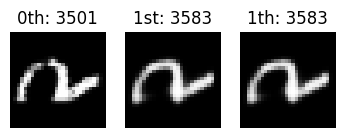

2, 5888.7431640625, 5545.056640625


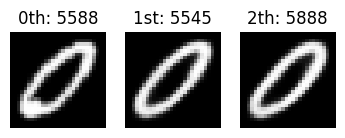

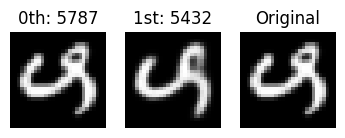

1, 6798.376953125, 6798.376953125


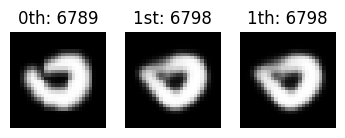

1, 5242.0263671875, 5242.0263671875


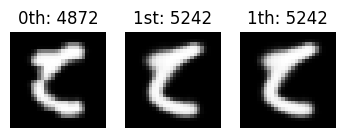

1, 5148.74462890625, 5148.74462890625


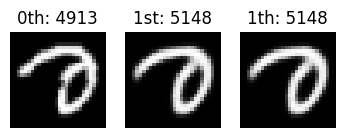

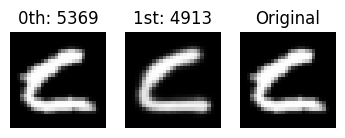

1, 4786.9990234375, 4786.9990234375


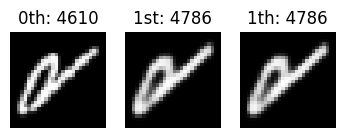

3, 4893.41015625, 4067.268798828125


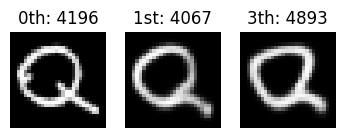

2, 2962.43017578125, 2791.416015625


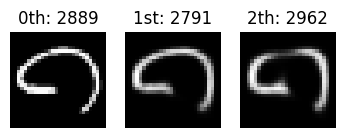

4, 4384.14453125, 3829.71142578125


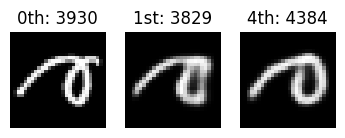

3, 4613.11083984375, 4495.720703125


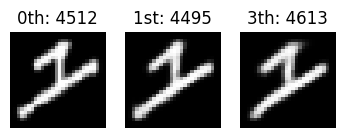

1, 2255.86376953125, 2255.86376953125


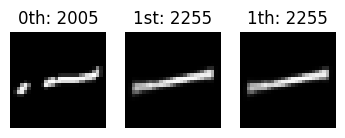

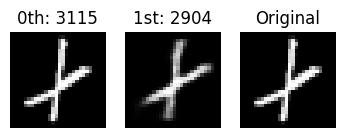

1, 4217.0810546875, 4217.0810546875


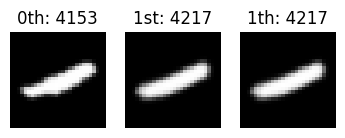

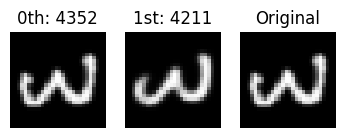

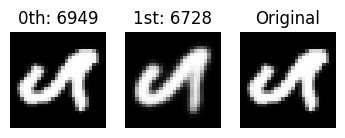

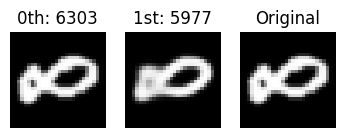

4, 5042.2412109375, 4990.6279296875


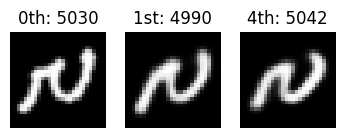

1, 4780.3896484375, 4780.3896484375


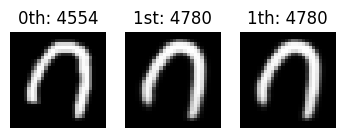

3, 4620.07421875, 4291.41796875


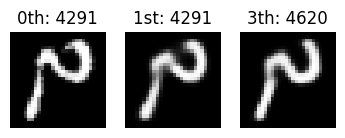

1, 4592.7490234375, 4592.7490234375


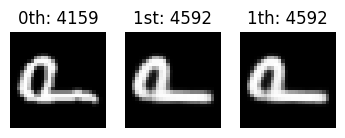

4, 4408.88134765625, 4273.98974609375


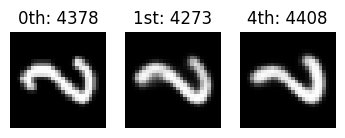

4, 5922.564453125, 5710.421875


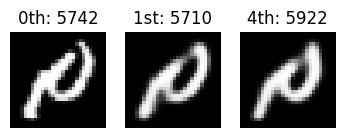

1, 5959.0068359375, 5959.0068359375


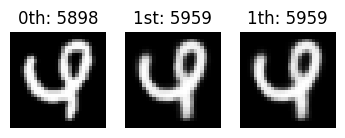

2, 4570.4853515625, 4295.66552734375


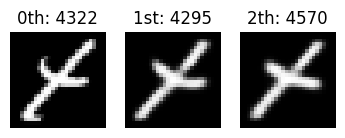

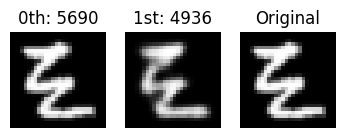

1, 4534.52734375, 4534.52734375


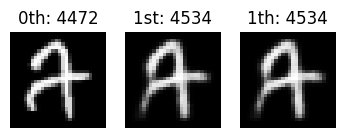

1, 4913.64111328125, 4913.64111328125


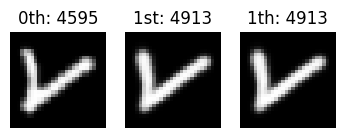

4, 3832.83544921875, 3479.90966796875


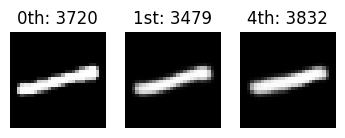

2, 7392.90576171875, 6976.21142578125


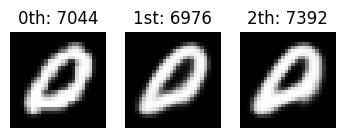

1, 5632.634765625, 5632.634765625


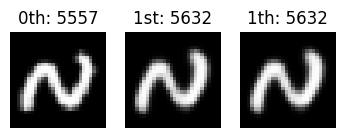

1, 4401.095703125, 4401.095703125


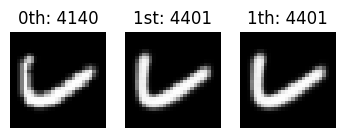

1, 3496.8427734375, 3496.8427734375


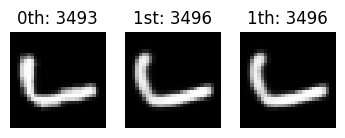

1, 4521.00048828125, 4521.00048828125


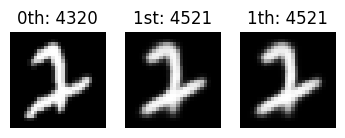

1, 6557.71142578125, 6557.71142578125


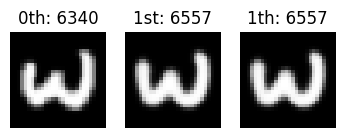

1, 6537.1728515625, 6537.1728515625


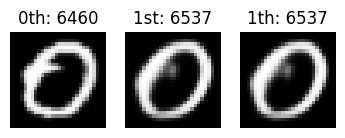

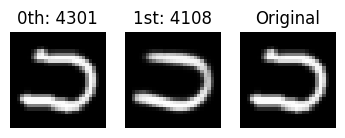

1, 7001.42138671875, 7001.42138671875


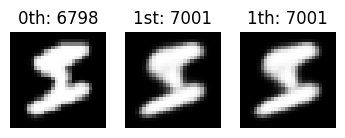

4, 5290.2412109375, 5062.7626953125


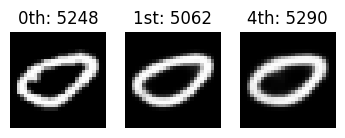

1, 6510.4501953125, 6510.4501953125


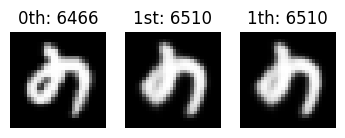

1, 3763.99462890625, 3763.99462890625


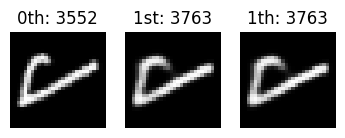

1, 6213.92822265625, 6213.92822265625


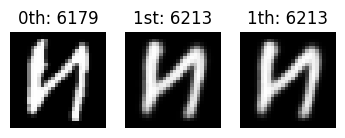

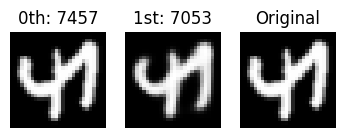

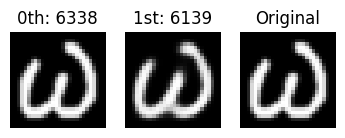

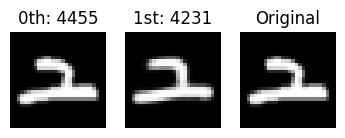

1, 4559.388671875, 4559.388671875


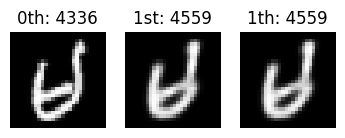

2, 6229.5234375, 5937.685546875


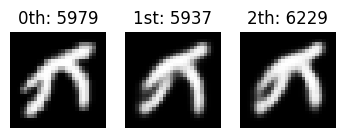

1, 5381.037109375, 5381.037109375


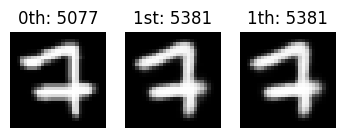

3, 5317.900390625, 5304.7080078125


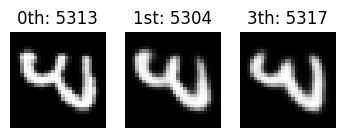

1, 4904.8056640625, 4904.8056640625


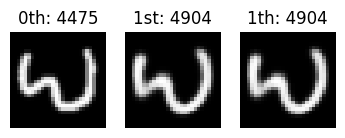

4, 4298.068359375, 4280.052734375


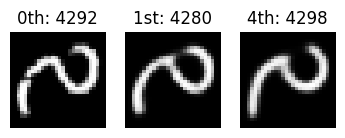

1, 4205.64794921875, 4205.64794921875


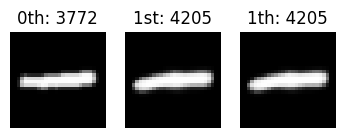

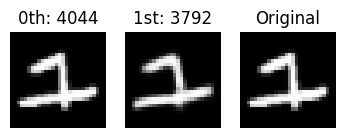

4, 4104.6318359375, 3711.6416015625


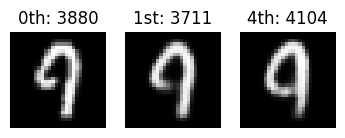

3, 4724.9521484375, 4498.3603515625


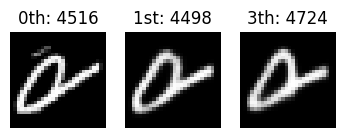

1, 5487.63232421875, 5487.63232421875


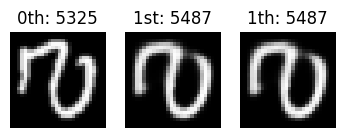

2, 7132.15380859375, 6729.5712890625


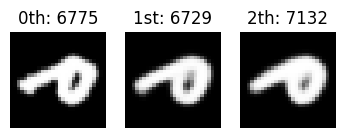

4, 7989.005859375, 7471.27685546875


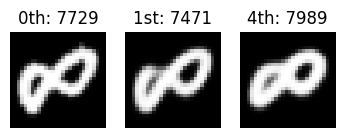

1, 3360.6416015625, 3360.6416015625


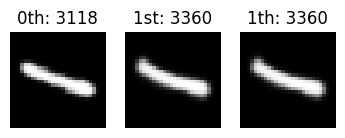

4, 3677.560546875, 3412.3994140625


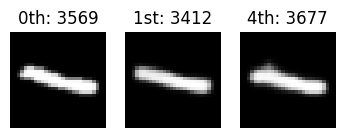

1, 3672.060791015625, 3672.060791015625


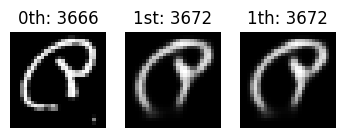

1, 5995.2109375, 5995.2109375


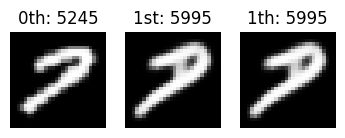

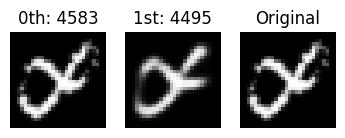

2, 5127.7880859375, 4880.5029296875


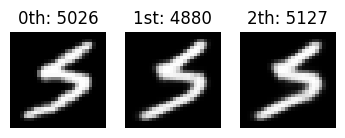

1, 2469.576171875, 2469.576171875


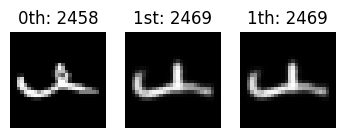

2, 3805.04541015625, 3690.430908203125


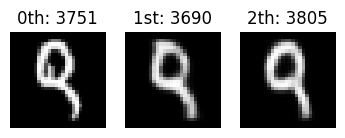

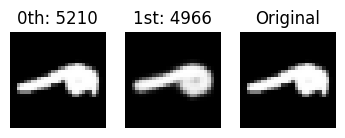

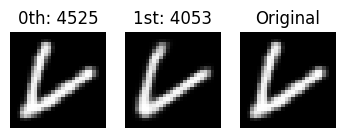

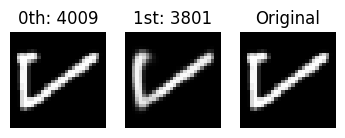

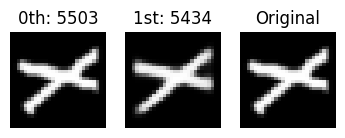

1, 4010.172119140625, 4010.172119140625


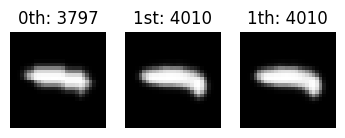

4, 4052.152587890625, 3827.462646484375


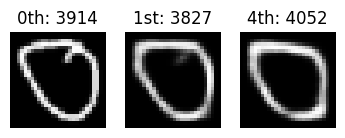

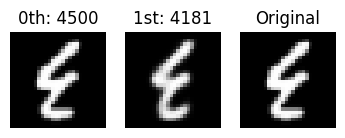

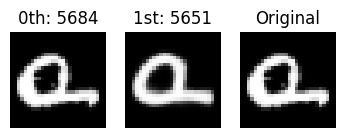

1, 4770.302734375, 4770.302734375


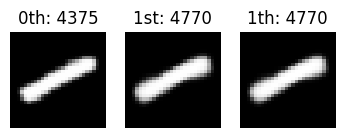

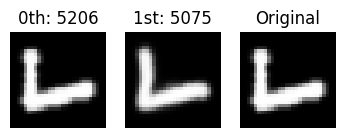

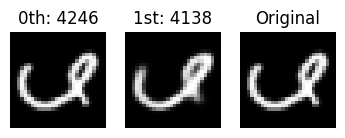

1, 3137.77783203125, 3137.77783203125


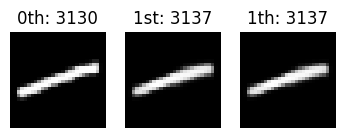

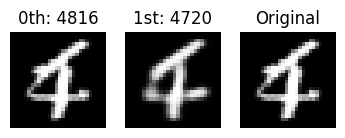

1, 6770.861328125, 6770.861328125


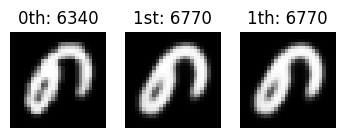

3, 3420.9853515625, 3306.22412109375


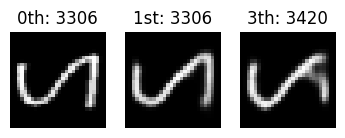

1, 4016.88330078125, 4016.88330078125


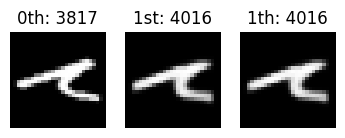

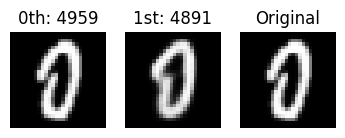

3, 3120.3076171875, 2820.4375


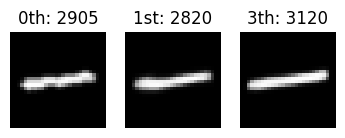

2, 4202.01123046875, 3909.033935546875


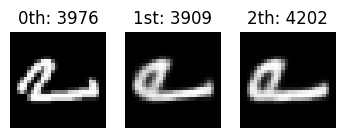

2, 7547.87060546875, 7231.1796875


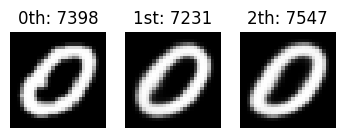

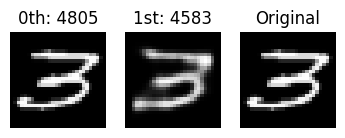

2, 5529.4453125, 5329.939453125


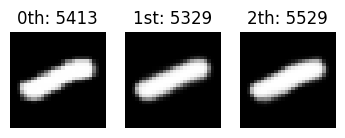

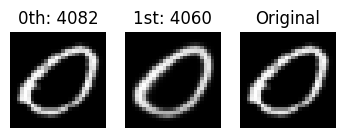

1, 5156.8974609375, 5156.8974609375


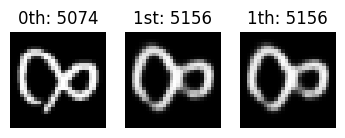

1, 4266.072265625, 4266.072265625


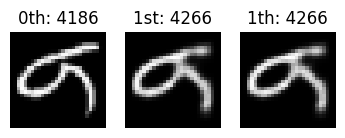

1, 6807.662109375, 6807.662109375


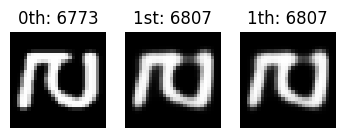

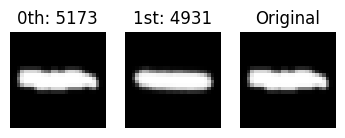

4, 6009.95703125, 5539.7587890625


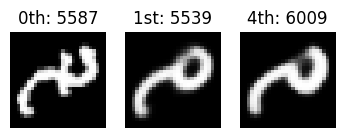

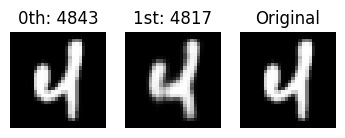

2, 8299.990234375, 7946.81396484375


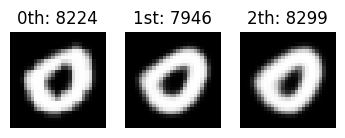

1, 5618.447265625, 5618.447265625


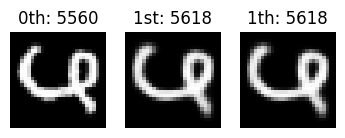

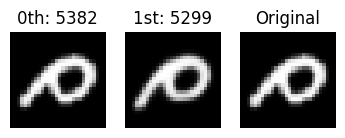

1, 6223.86767578125, 6223.86767578125


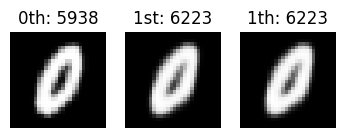

1, 4024.89208984375, 4024.89208984375


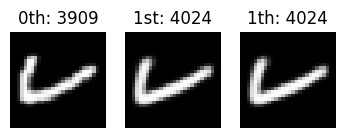

1, 9207.52734375, 9207.52734375


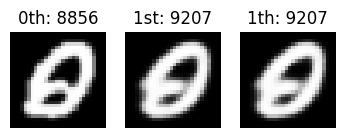

3, 3925.05810546875, 3859.92578125


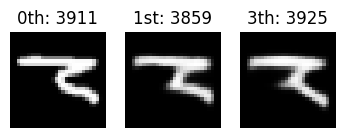

1, 3496.3544921875, 3496.3544921875


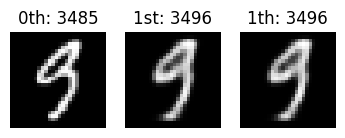

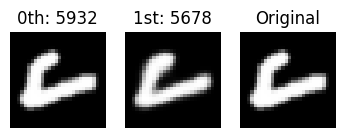

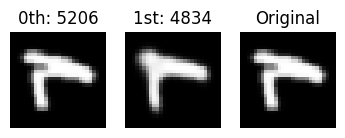

1, 3150.785400390625, 3150.785400390625


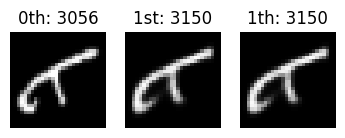

1, 4502.1533203125, 4502.1533203125


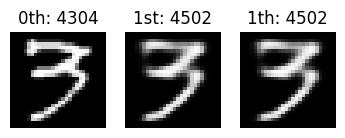

1, 3656.05615234375, 3656.05615234375


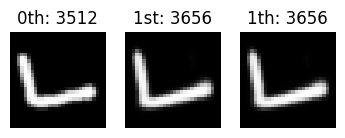

1, 3030.330322265625, 3030.330322265625


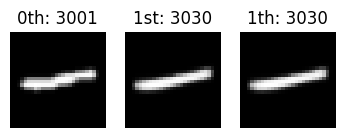

3, 3978.447265625, 3698.32177734375


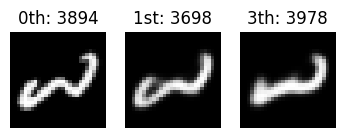

1, 3580.57763671875, 3580.57763671875


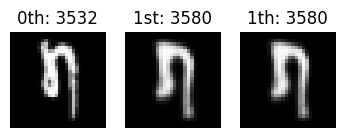

3, 6790.072265625, 6600.8486328125


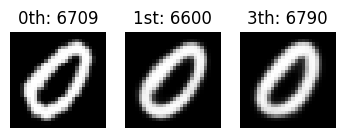

1, 3965.82763671875, 3965.82763671875


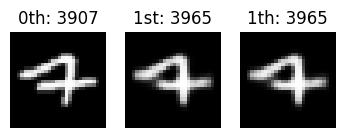

4, 3238.50341796875, 2916.50146484375


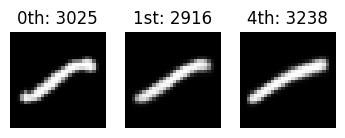

3, 4588.76904296875, 4233.115234375


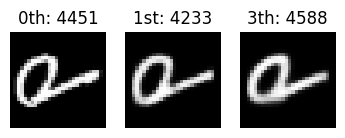

1, 5347.34375, 5347.34375


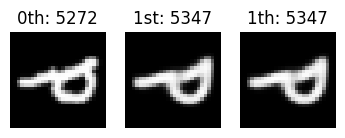

1, 5098.71923828125, 5098.71923828125


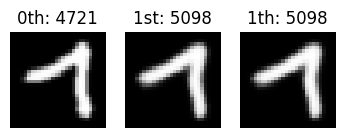

1, 5382.9541015625, 5382.9541015625


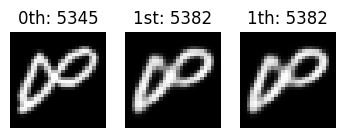

1, 4622.9375, 4622.9375


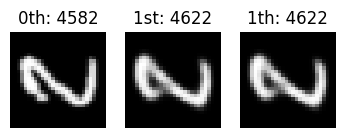

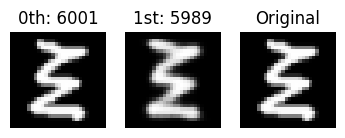

1, 7041.00537109375, 7041.00537109375


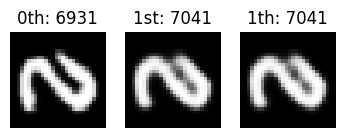

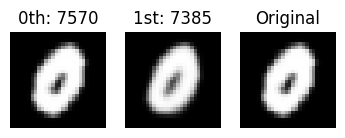

1, 3024.83056640625, 3024.83056640625


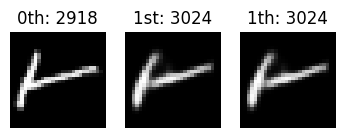

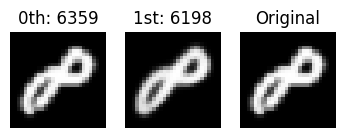

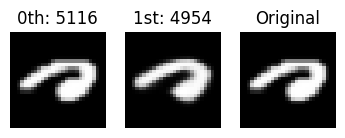

1, 4557.33740234375, 4557.33740234375


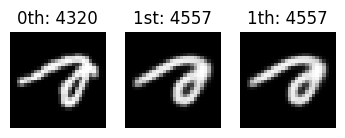

2, 6758.4169921875, 6670.2470703125


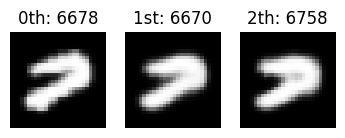

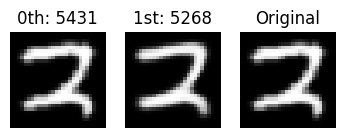

1, 4601.15625, 4601.15625


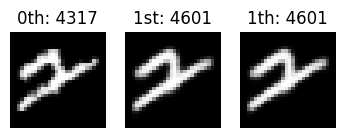

1, 4078.64306640625, 4078.64306640625


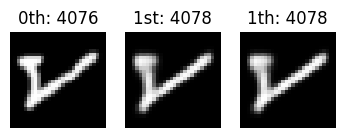

1, 2686.723388671875, 2686.723388671875


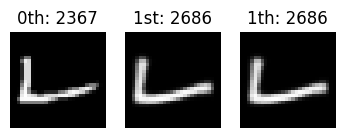

1, 3757.021728515625, 3757.021728515625


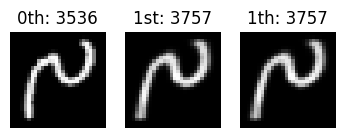

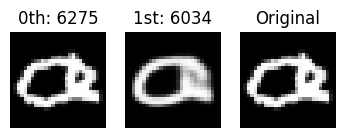

1, 3665.70849609375, 3665.70849609375


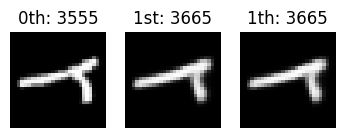

3, 3483.901611328125, 3243.44970703125


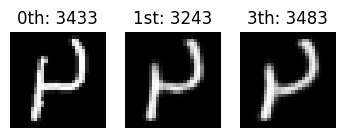

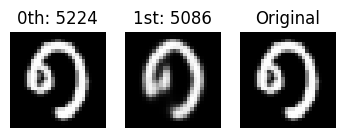

3, 5036.521484375, 4877.7314453125


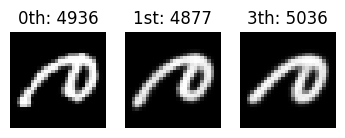

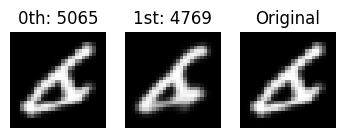

1, 4289.9248046875, 4289.9248046875


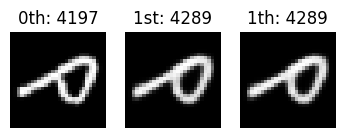

3, 3761.3173828125, 3485.27587890625


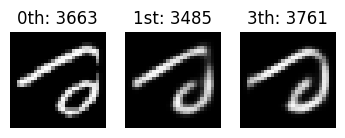

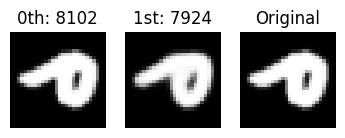

1, 3321.43603515625, 3321.43603515625


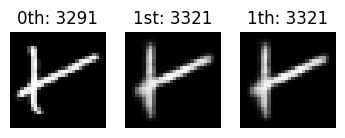

1, 5373.6171875, 5373.6171875


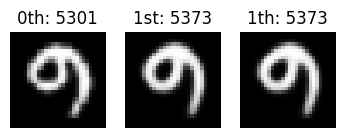

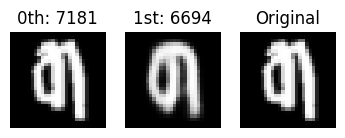

1, 3398.60009765625, 3398.60009765625


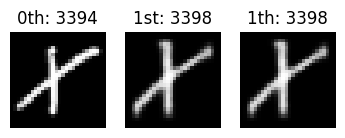

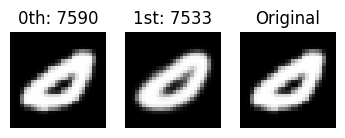

1, 5804.47265625, 5804.47265625


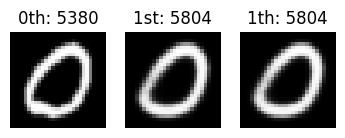

1, 4619.6845703125, 4619.6845703125


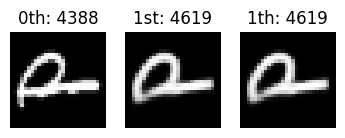

4, 4753.8974609375, 4645.669921875


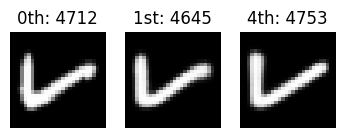

1, 3675.853759765625, 3675.853759765625


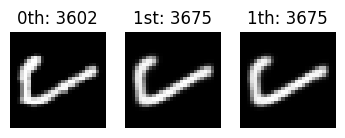

2, 5071.7998046875, 4792.5615234375


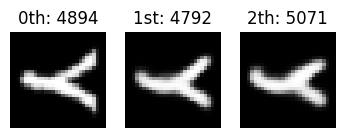

1, 6566.640625, 6566.640625


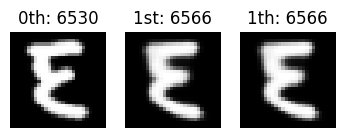

2, 5933.46875, 5508.4765625


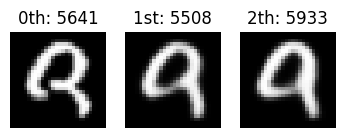

4, 2325.166748046875, 2096.62255859375


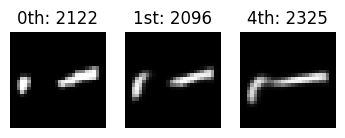

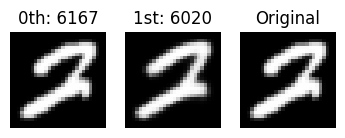

1, 7985.591796875, 7985.591796875


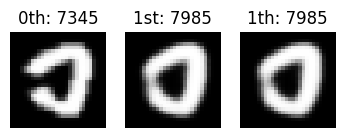

1, 3043.1025390625, 3043.1025390625


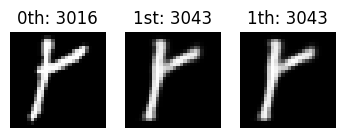

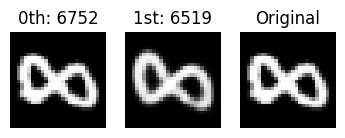

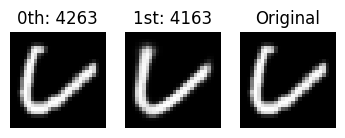

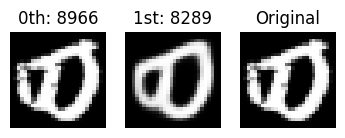

1, 6514.904296875, 6514.904296875


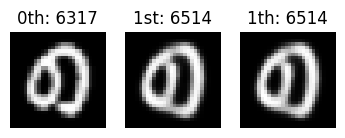

1, 5828.2421875, 5828.2421875


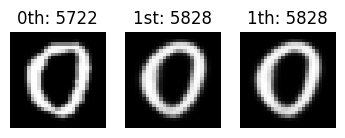

2, 6164.62060546875, 5924.54052734375


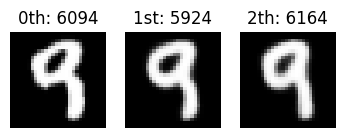

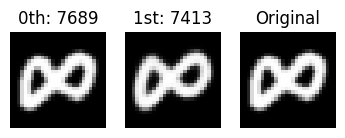

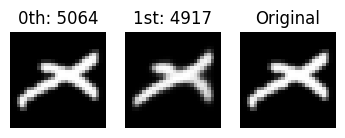

1, 7077.892578125, 7077.892578125


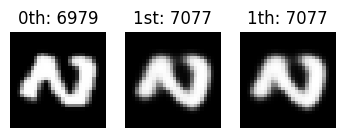

1, 4021.947265625, 4021.947265625


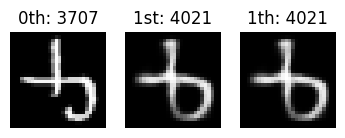

4, 5904.423828125, 5534.19482421875


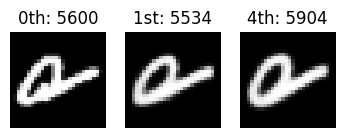

1, 5856.8154296875, 5856.8154296875


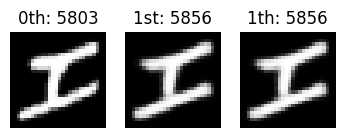

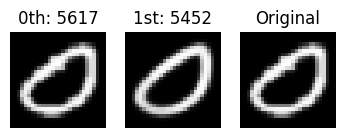

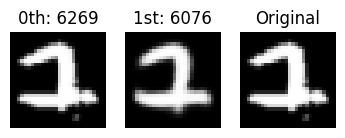

2, 5614.3154296875, 5547.60302734375


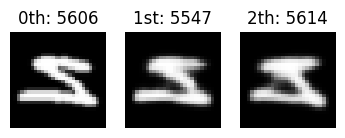

1, 5126.0126953125, 5126.0126953125


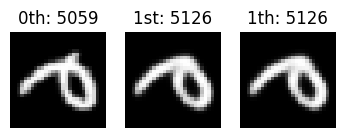

1, 6437.85595703125, 6437.85595703125


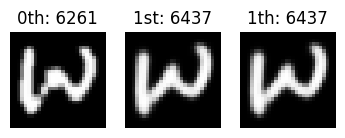

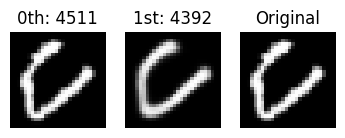

1, 4150.9541015625, 4150.9541015625


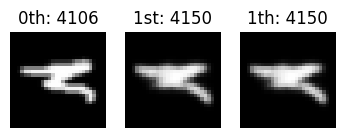

1, 3270.3369140625, 3270.3369140625


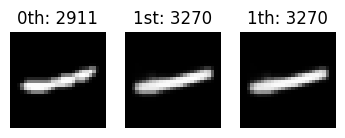

1, 5170.955078125, 5170.955078125


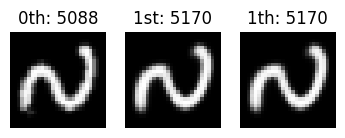

1, 5184.85205078125, 5184.85205078125


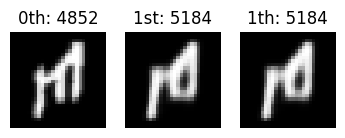

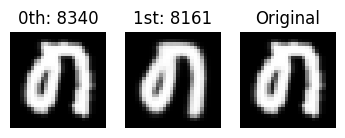

2, 3041.532470703125, 2850.04541015625


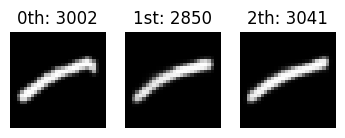

1, 5398.2294921875, 5398.2294921875


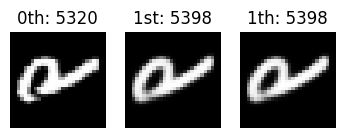

1, 6271.01953125, 6271.01953125


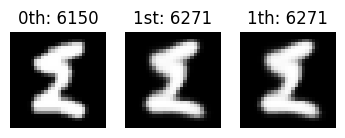

1, 5220.384765625, 5220.384765625


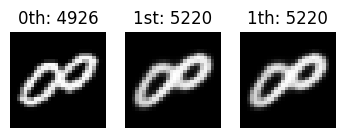

3, 5304.1435546875, 5078.580078125


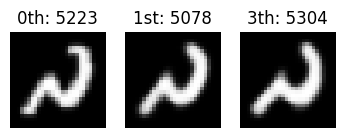

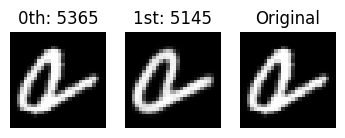

1, 4099.9287109375, 4099.9287109375


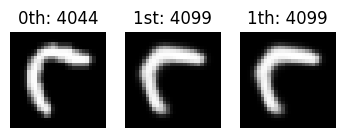

2, 6434.796875, 6142.111328125


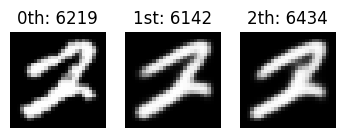

2, 4857.4482421875, 4618.05517578125


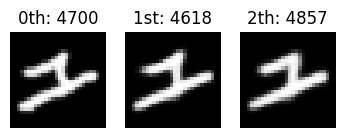

1, 2978.18359375, 2978.18359375


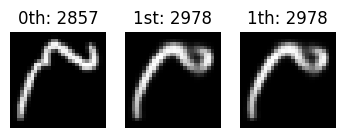

2, 4644.2880859375, 4320.2314453125


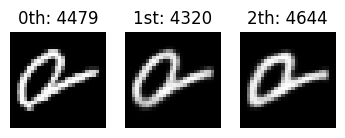

1, 4983.525390625, 4983.525390625


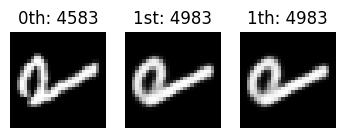

1, 3843.685791015625, 3843.685791015625


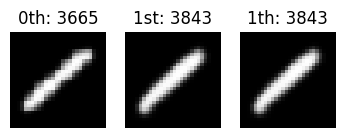

2, 6464.5908203125, 6204.64111328125


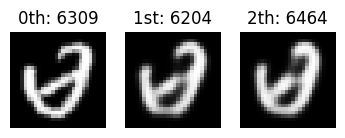

1, 3673.70947265625, 3673.70947265625


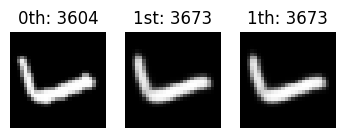

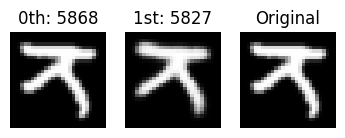

1, 6969.00390625, 6969.00390625


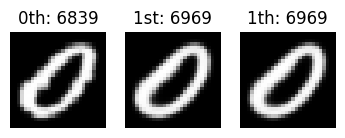

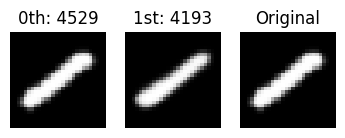

4, 5604.36669921875, 4930.4384765625


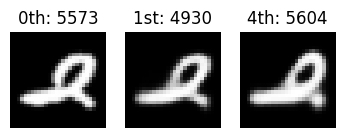

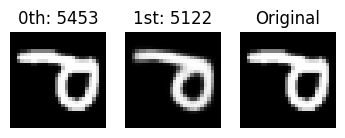

1, 7126.935546875, 7126.935546875


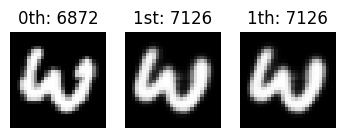

1, 6791.009765625, 6791.009765625


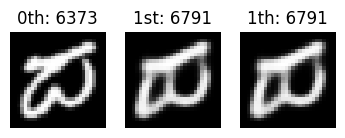

1, 3850.89697265625, 3850.89697265625


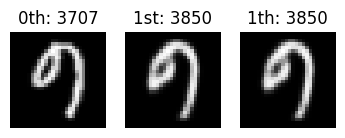

1, 5017.7802734375, 5017.7802734375


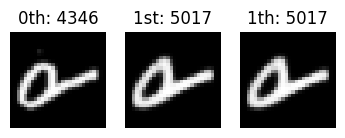

1, 4868.82861328125, 4868.82861328125


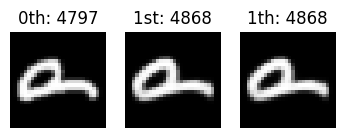

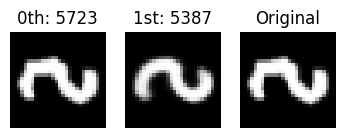

1, 6706.9111328125, 6706.9111328125


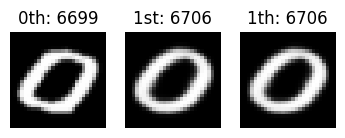

1, 5274.5986328125, 5274.5986328125


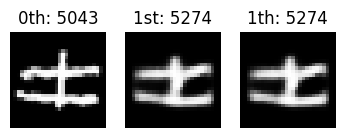

1, 5761.796875, 5761.796875


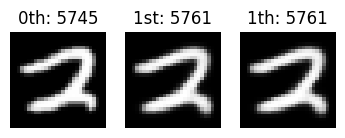

3, 4623.2294921875, 4474.671875


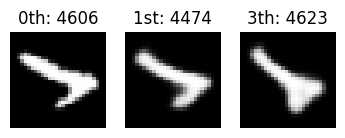

1, 4737.712890625, 4737.712890625


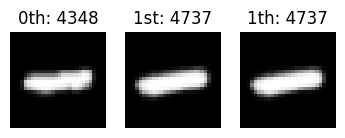

2, 4828.6171875, 4509.2041015625


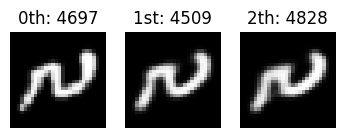

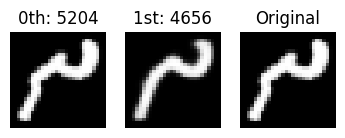

1, 5113.6162109375, 5113.6162109375


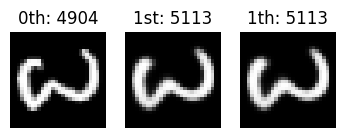

2, 6272.55859375, 5974.62890625


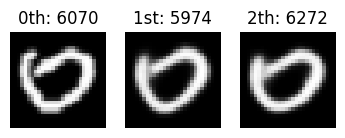

1, 5016.2080078125, 5016.2080078125


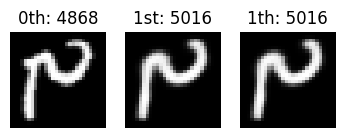

2, 6291.5107421875, 5916.74755859375


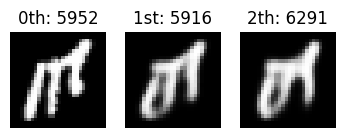

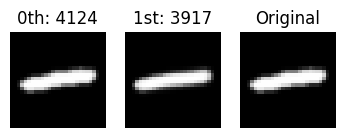

1, 6096.78125, 6096.78125


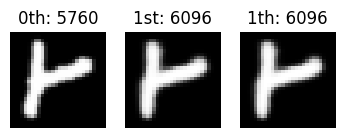

1, 5347.626953125, 5347.626953125


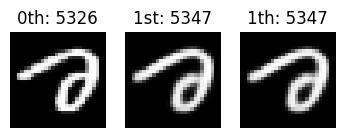

1, 6168.2880859375, 6168.2880859375


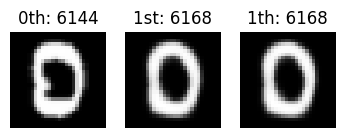

1, 3727.37548828125, 3727.37548828125


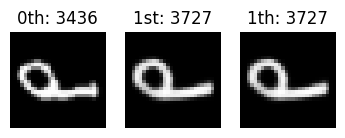

1, 6201.923828125, 6201.923828125


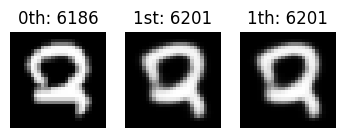

1, 3557.0048828125, 3557.0048828125


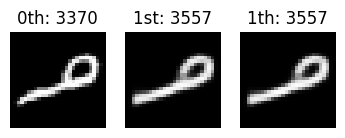

3, 4669.7958984375, 4444.3935546875


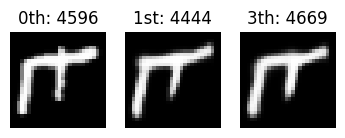

1, 4466.697265625, 4466.697265625


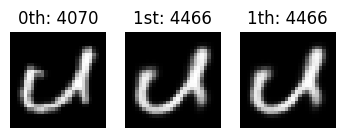

2, 3360.16796875, 3177.3251953125


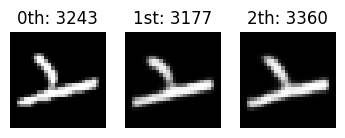

1, 4786.138671875, 4786.138671875


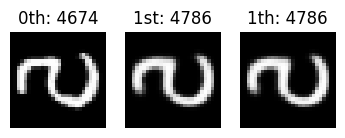

2, 2541.36865234375, 2272.2978515625


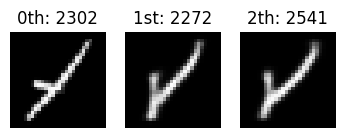

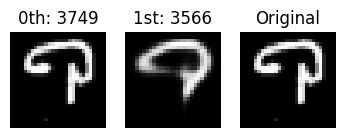

3, 4435.70166015625, 4151.51611328125


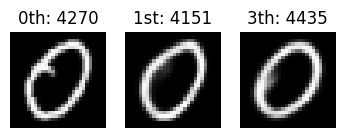

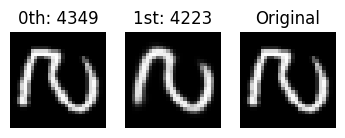

1, 6794.560546875, 6794.560546875


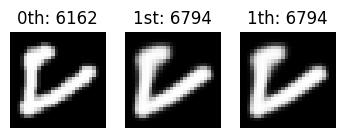

3, 7063.220703125, 6797.541015625


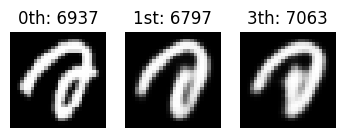

2, 5546.66162109375, 5156.013671875


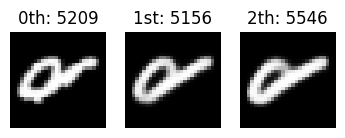

1, 4307.7744140625, 4307.7744140625


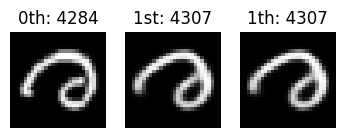

1, 5609.712890625, 5609.712890625


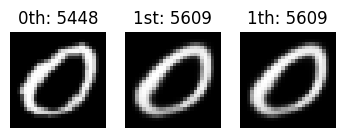

1, 5711.7333984375, 5711.7333984375


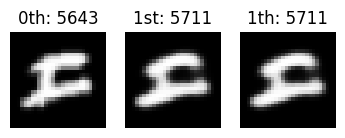

1, 4834.3193359375, 4834.3193359375


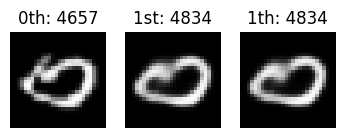

1, 5706.8408203125, 5706.8408203125


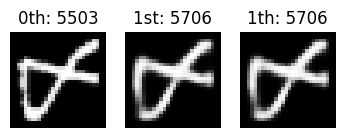

1, 7292.12060546875, 7292.12060546875


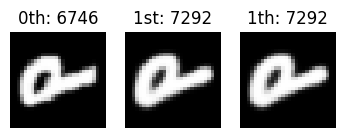

1, 8360.3525390625, 8360.3525390625


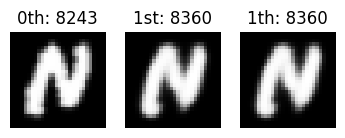

3, 5934.46240234375, 5793.5078125


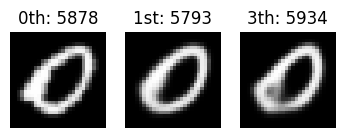

3, 3865.980224609375, 3801.805908203125


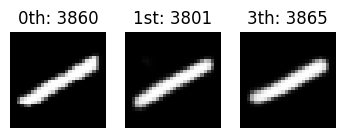

2, 7379.1240234375, 6681.6923828125


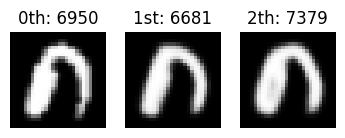

1, 5028.900390625, 5028.900390625


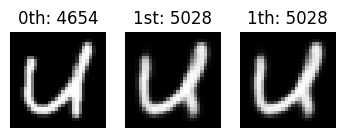

2, 2024.9139404296875, 1724.54736328125


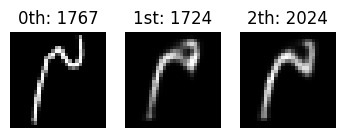

2, 4439.3544921875, 4251.90380859375


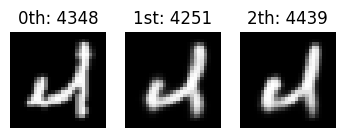

2, 5601.78955078125, 5260.484375


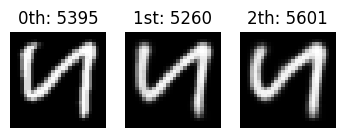

2, 6887.45263671875, 6512.3330078125


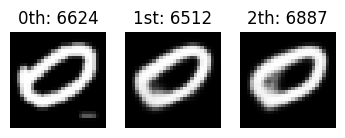

1, 4004.798583984375, 4004.798583984375


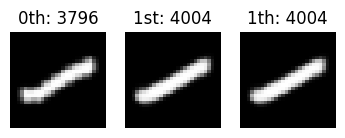

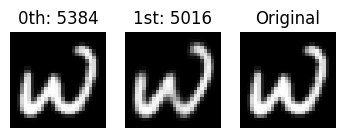

1, 5457.73046875, 5457.73046875


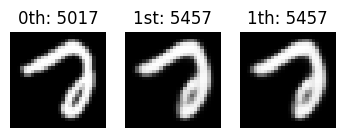

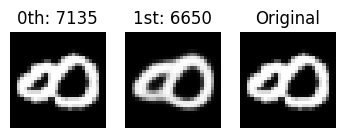

1, 4797.87255859375, 4797.87255859375


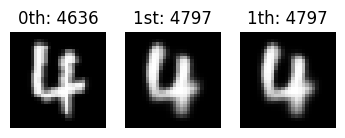

1, 3360.787109375, 3360.787109375


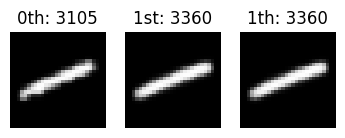

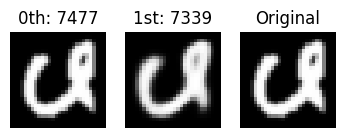

1, 3332.45263671875, 3332.45263671875


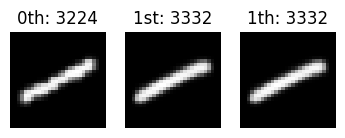

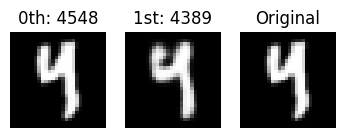

1, 4137.412109375, 4137.412109375


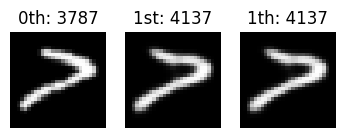

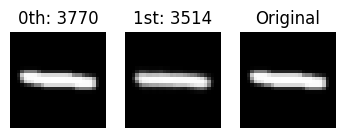

3, 6372.7587890625, 6229.4794921875


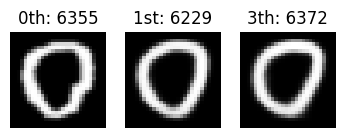

1, 6116.990234375, 6116.990234375


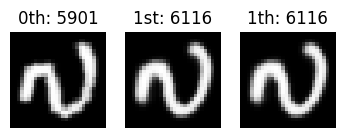

1, 6103.8232421875, 6103.8232421875


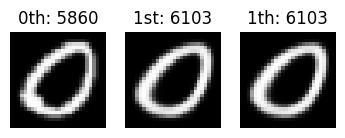

1, 5526.8095703125, 5526.8095703125


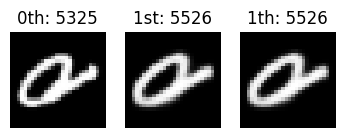

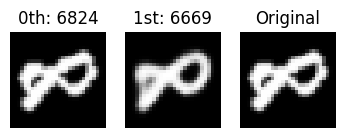

1, 5360.32958984375, 5360.32958984375


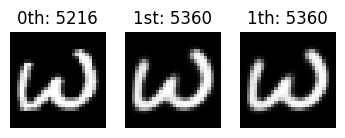

2, 3831.04833984375, 3467.982666015625


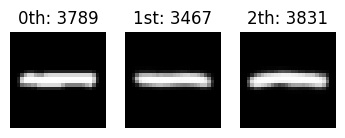

4, 5832.2138671875, 5631.357421875


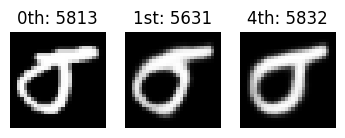

1, 5086.87890625, 5086.87890625


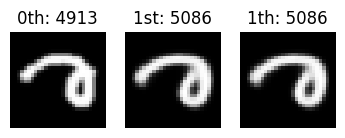

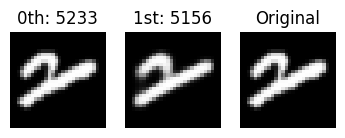

1, 4226.63623046875, 4226.63623046875


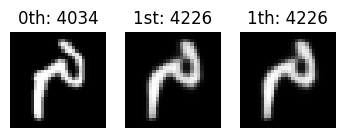

1, 5390.97802734375, 5390.97802734375


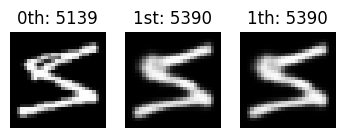

1, 6087.51953125, 6087.51953125


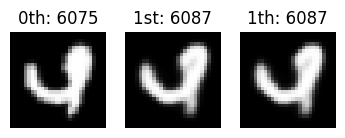

1, 4583.8837890625, 4583.8837890625


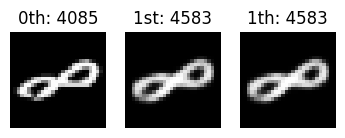

2, 7303.50537109375, 6992.2060546875


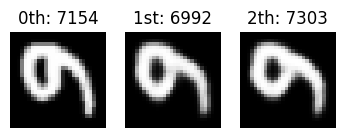

1, 6059.7041015625, 6059.7041015625


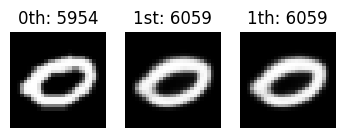

1, 4495.4033203125, 4495.4033203125


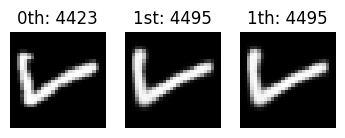

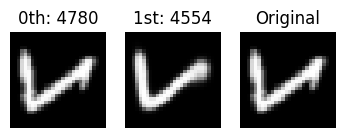

1, 7214.923828125, 7214.923828125


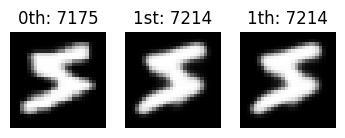

1, 3503.3212890625, 3503.3212890625


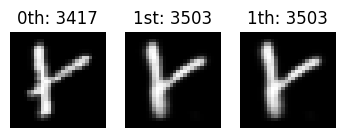

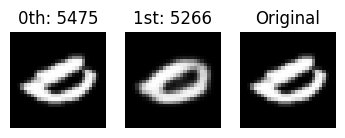

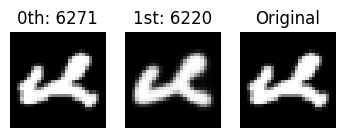

1, 5245.42724609375, 5245.42724609375


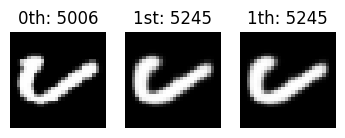

1, 5820.27685546875, 5820.27685546875


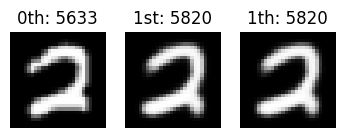

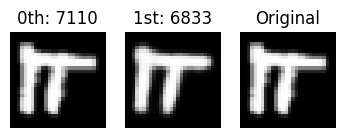

3, 7188.8330078125, 6973.138671875


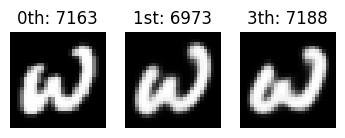

1, 4606.53564453125, 4606.53564453125


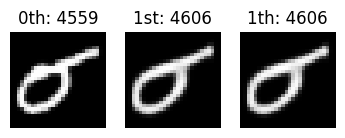

1, 5013.8154296875, 5013.8154296875


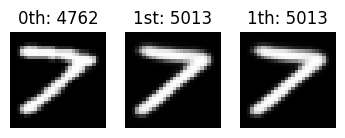

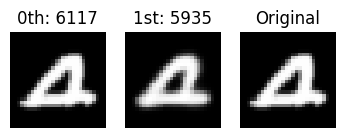

1, 6437.212890625, 6437.212890625


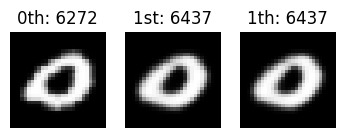

4, 3726.3544921875, 3666.52880859375


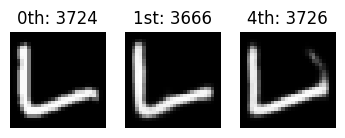

1, 6313.4560546875, 6313.4560546875


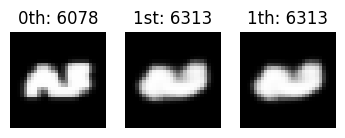

1, 4452.205078125, 4452.205078125


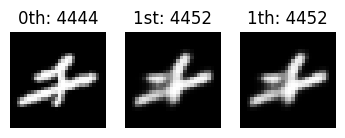

3, 7522.6806640625, 7416.388671875


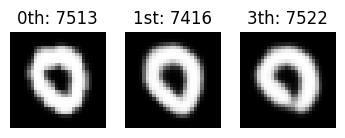

1, 3488.76025390625, 3488.76025390625


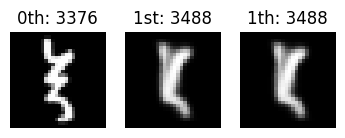

1, 5660.62744140625, 5660.62744140625


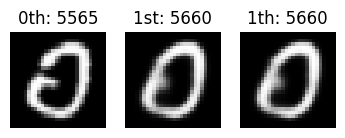

1, 3946.74462890625, 3946.74462890625


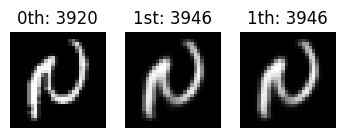

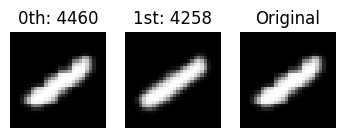

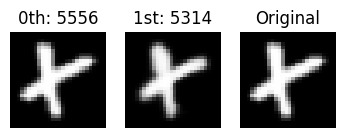

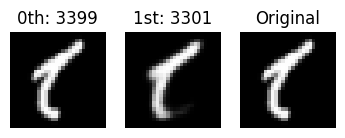

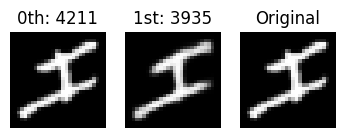

1, 3249.4189453125, 3249.4189453125


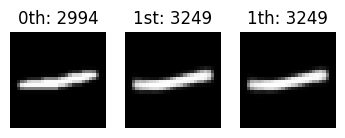

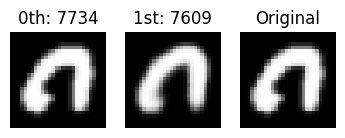

1, 4101.9267578125, 4101.9267578125


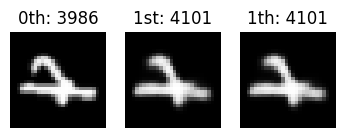

2, 5088.5673828125, 4493.4091796875


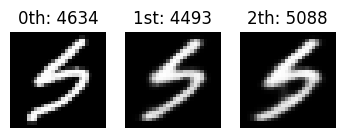

1, 4160.9384765625, 4160.9384765625


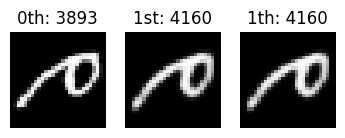

2, 4121.3330078125, 3945.993896484375


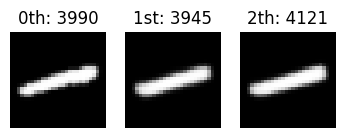

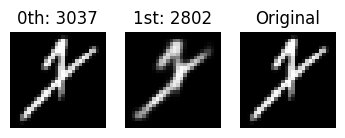

1, 4299.69580078125, 4299.69580078125


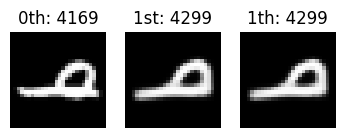

1, 6792.45458984375, 6792.45458984375


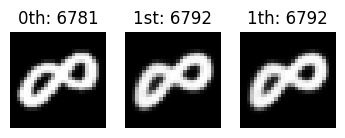

1, 2527.75732421875, 2527.75732421875


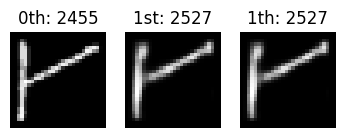

4, 4352.8134765625, 3953.001953125


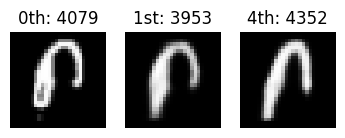

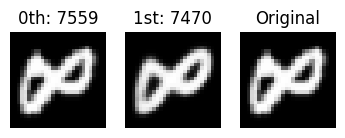

1, 4094.80859375, 4094.80859375


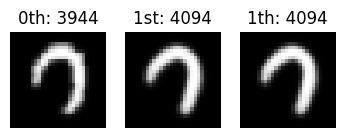

1, 4293.9833984375, 4293.9833984375


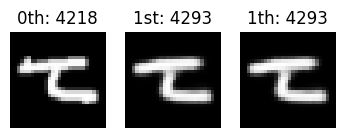

3, 5984.478515625, 5484.4560546875


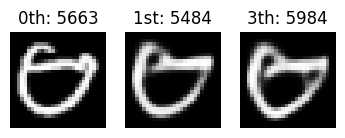

1, 3398.920654296875, 3398.920654296875


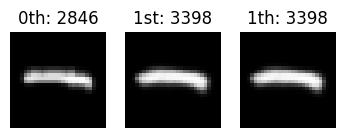

2, 4322.66357421875, 4133.728515625


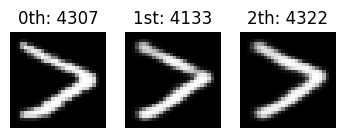

1, 8367.8896484375, 8367.8896484375


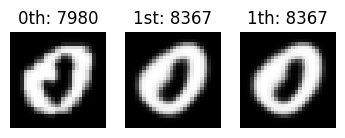

1, 6094.97265625, 6094.97265625


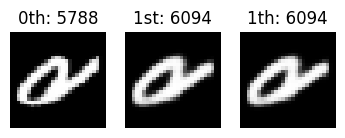

2, 3094.92919921875, 2856.03662109375


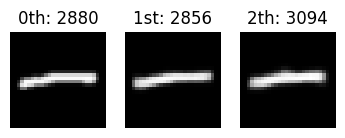

1, 3534.83837890625, 3534.83837890625


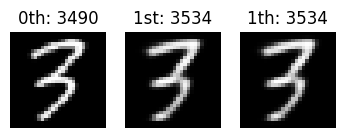

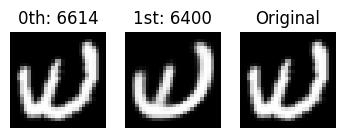

4, 4010.765625, 3604.52197265625


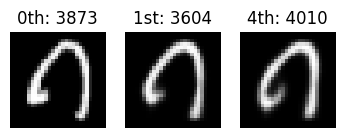

1, 5510.31005859375, 5510.31005859375


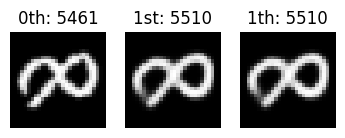

3, 4118.3681640625, 3919.06787109375


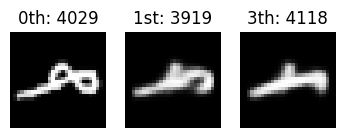

1, 3916.970703125, 3916.970703125


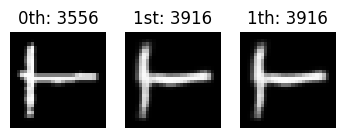

1, 5021.8232421875, 5021.8232421875


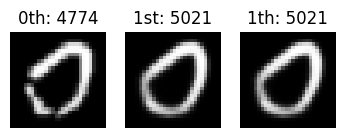

1, 2544.913330078125, 2544.913330078125


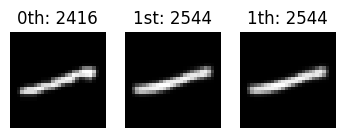

1, 5724.490234375, 5724.490234375


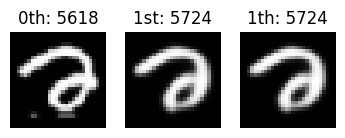

2, 8347.791015625, 7920.763671875


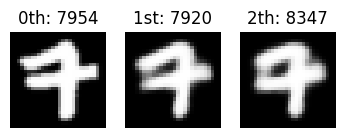

1, 4097.01904296875, 4097.01904296875


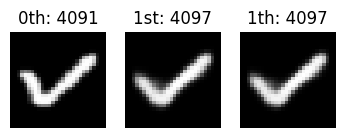

1, 4748.47509765625, 4748.47509765625


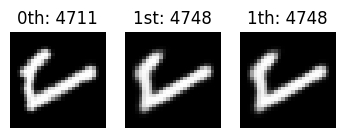

1, 5671.37109375, 5671.37109375


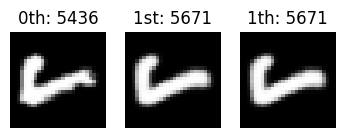

1, 6270.61962890625, 6270.61962890625


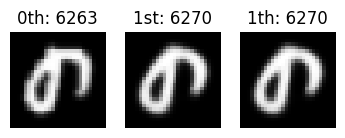

1, 5915.75048828125, 5915.75048828125


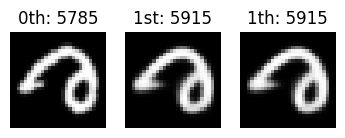

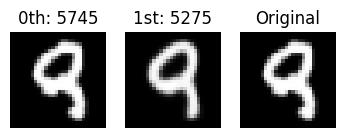

1, 5877.2158203125, 5877.2158203125


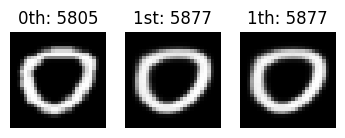

1, 4485.13525390625, 4485.13525390625


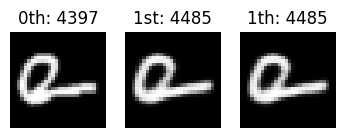

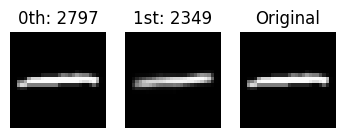

1, 3369.29345703125, 3369.29345703125


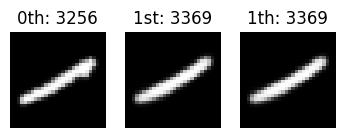

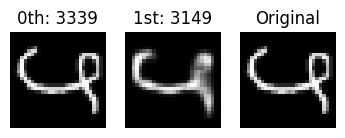

1, 5643.9228515625, 5643.9228515625


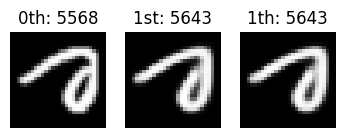

1, 2803.304931640625, 2803.304931640625


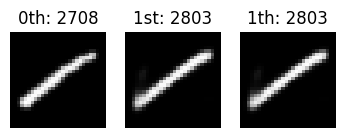

1, 7963.40283203125, 7963.40283203125


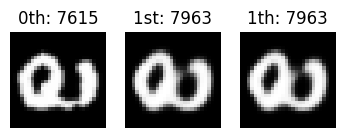

1, 3866.78955078125, 3866.78955078125


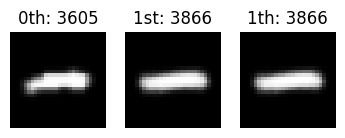

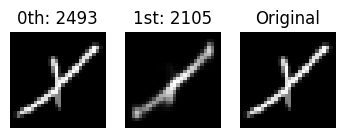

1, 6198.20849609375, 6198.20849609375


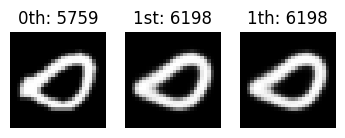

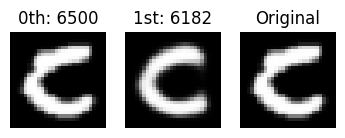

1, 6832.5009765625, 6832.5009765625


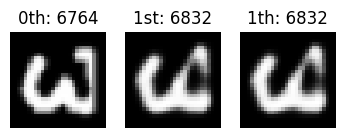

1, 3359.52197265625, 3359.52197265625


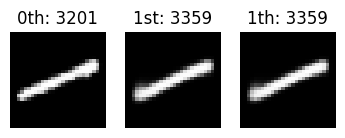

1, 4075.018798828125, 4075.018798828125


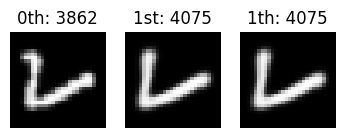

1, 4783.80078125, 4783.80078125


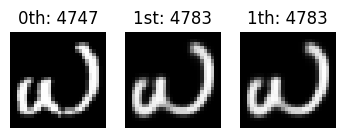

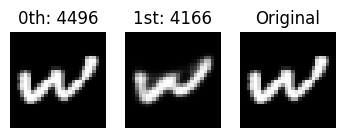

1, 3658.3388671875, 3658.3388671875


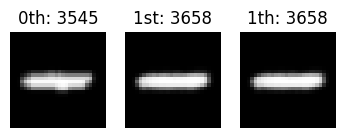

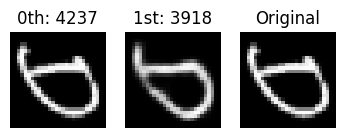

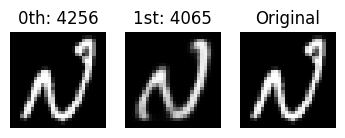

3, 3450.3115234375, 3272.5615234375


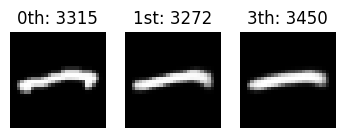

1, 7876.6328125, 7876.6328125


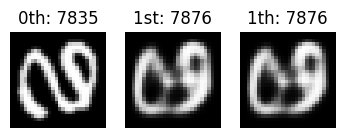

1, 3698.22021484375, 3698.22021484375


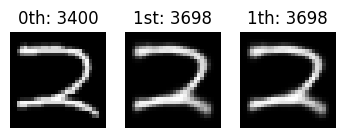

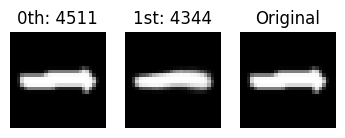

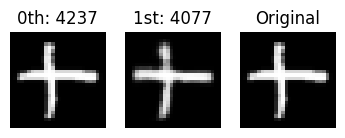

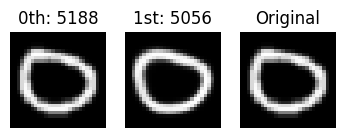

1, 3307.505615234375, 3307.505615234375


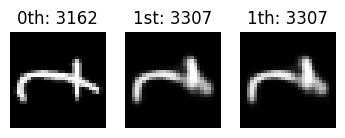

1, 3471.52001953125, 3471.52001953125


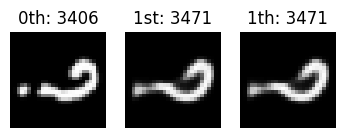

3, 6768.556640625, 6267.271484375


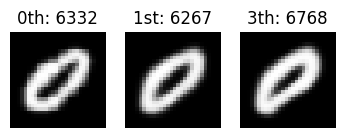

2, 5603.1728515625, 5191.00244140625


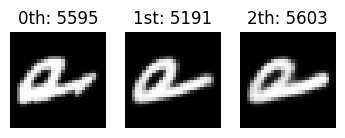

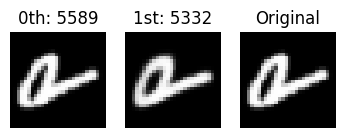

1, 5179.76806640625, 5179.76806640625


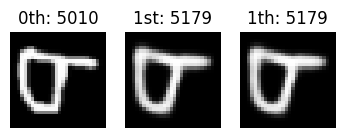

3, 3427.3173828125, 3075.76220703125


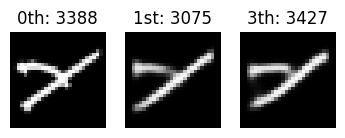

1, 3746.1982421875, 3746.1982421875


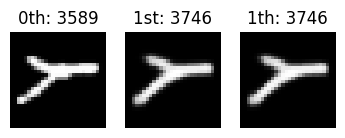

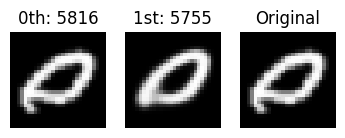

1, 4908.66015625, 4908.66015625


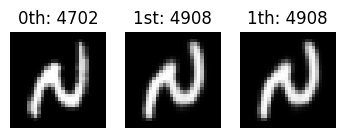

4, 6141.3291015625, 5521.8876953125


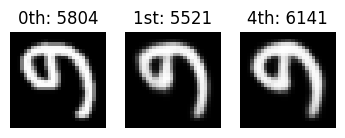

1, 6259.93505859375, 6259.93505859375


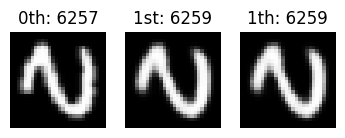

1, 4436.30224609375, 4436.30224609375


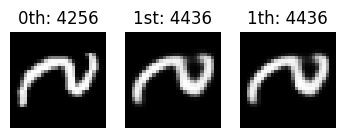

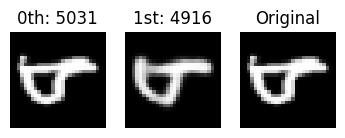

1, 5124.146484375, 5124.146484375


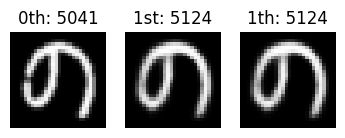

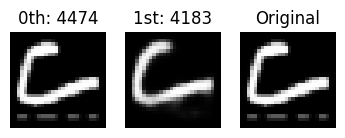

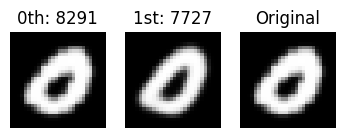

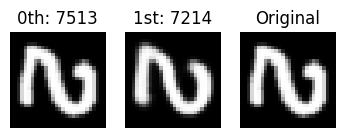

1, 5048.61474609375, 5048.61474609375


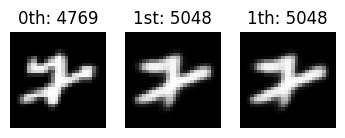

2, 5844.7041015625, 5554.8408203125


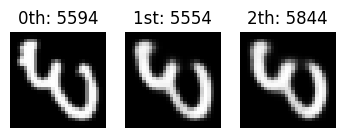

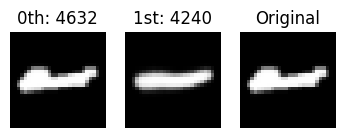

1, 5283.0380859375, 5283.0380859375


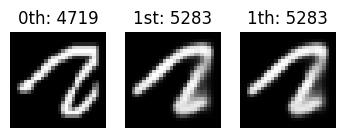

4, 5770.19921875, 5673.0341796875


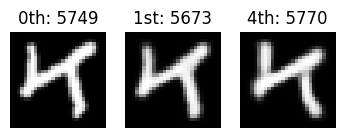

1, 4538.77978515625, 4538.77978515625


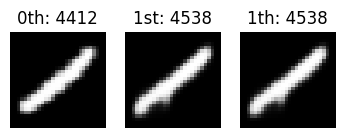

2, 6410.666015625, 6075.07861328125


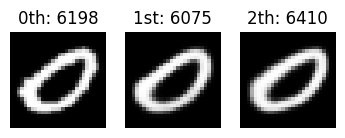

1, 3717.970703125, 3717.970703125


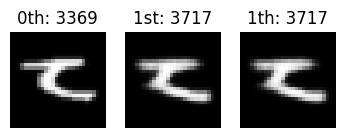

1, 4916.40966796875, 4916.40966796875


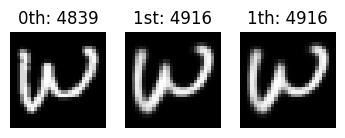

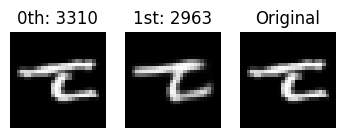

1, 5783.8525390625, 5783.8525390625


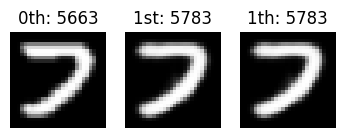

1, 5028.953125, 5028.953125


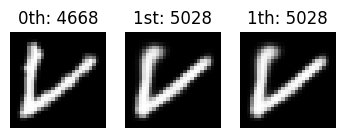

2, 6852.72607421875, 6817.6064453125


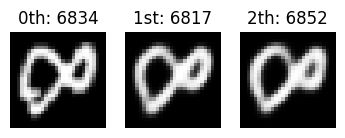

3, 4903.8486328125, 4696.0576171875


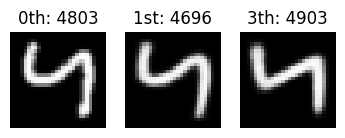

1, 5201.5068359375, 5201.5068359375


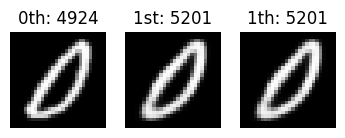

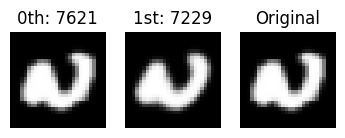

1, 7995.5234375, 7995.5234375


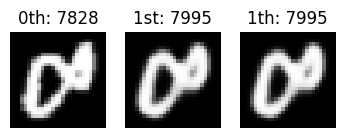

1, 3876.43359375, 3876.43359375


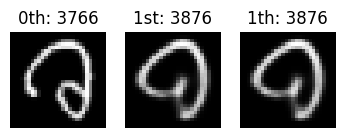

1, 4890.91162109375, 4890.91162109375


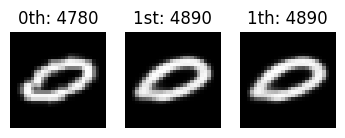

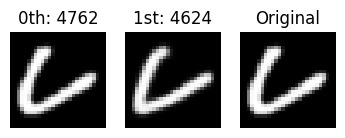

3, 4588.1572265625, 4577.8994140625


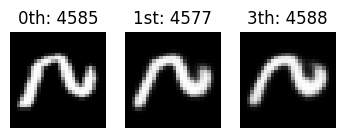

1, 5157.1328125, 5157.1328125


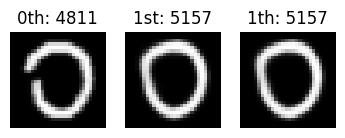

1, 6637.7041015625, 6637.7041015625


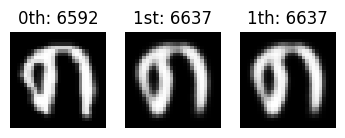

1, 3800.72802734375, 3800.72802734375


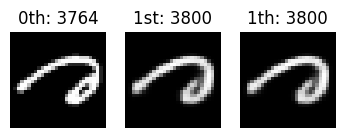

1, 2882.16064453125, 2882.16064453125


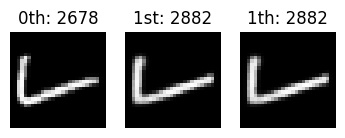

1, 4428.16796875, 4428.16796875


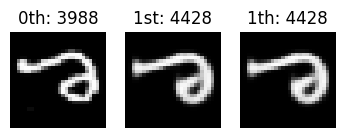

2, 6583.33740234375, 6342.4619140625


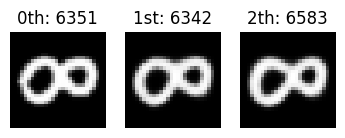

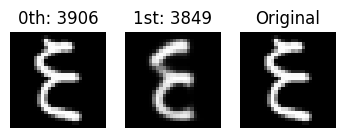

1, 4495.2314453125, 4495.2314453125


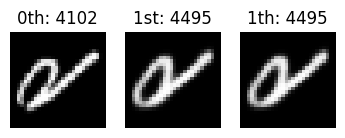

1, 3138.101806640625, 3138.101806640625


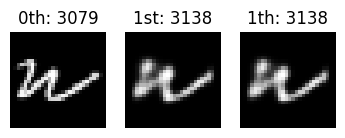

2, 6772.9931640625, 6576.6904296875


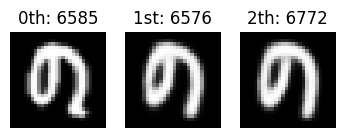

1, 6363.1728515625, 6363.1728515625


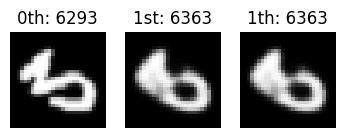

1, 4771.876953125, 4771.876953125


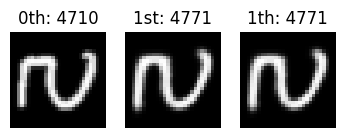

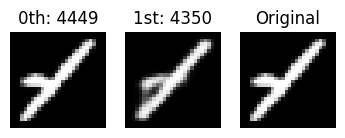

1, 4652.6064453125, 4652.6064453125


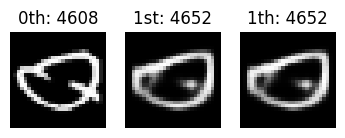

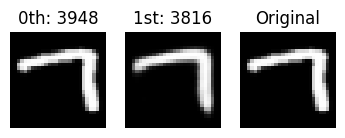

1, 4953.63720703125, 4953.63720703125


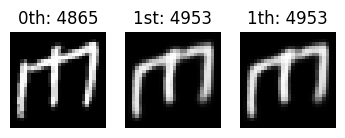

1, 4385.333984375, 4385.333984375


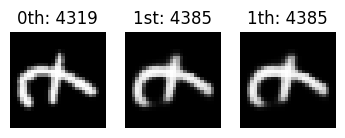

1, 5494.05908203125, 5494.05908203125


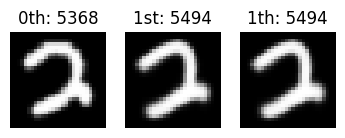

2, 6040.2294921875, 5844.64599609375


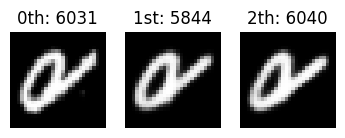

1, 6662.296875, 6662.296875


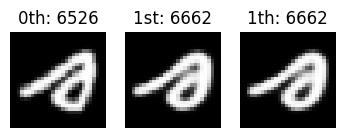

1, 4018.56201171875, 4018.56201171875


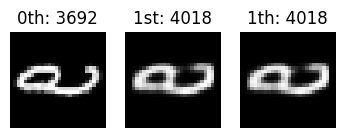

1, 4483.072265625, 4483.072265625


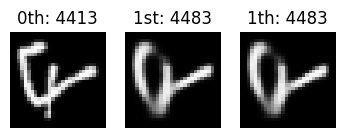

1, 6358.4716796875, 6358.4716796875


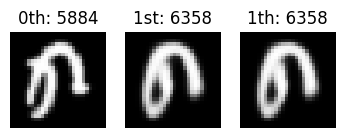

1, 4579.333984375, 4579.333984375


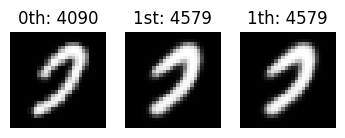

4, 6370.927734375, 6216.91015625


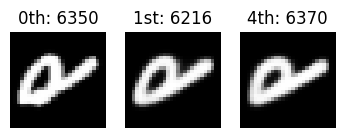

1, 6123.01953125, 6123.01953125


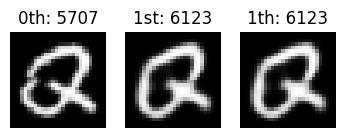

1, 5804.31884765625, 5804.31884765625


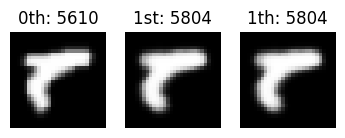

1, 4685.599609375, 4685.599609375


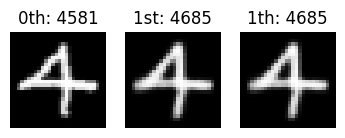

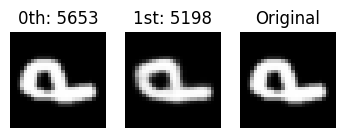

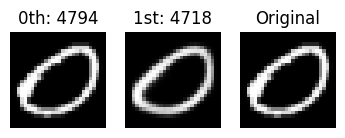

1, 3241.4599609375, 3241.4599609375


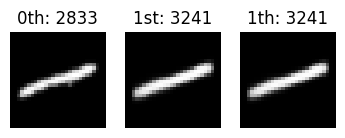

1, 5460.4833984375, 5460.4833984375


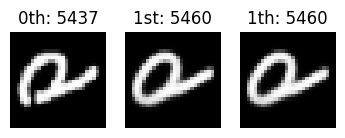

1, 5088.08984375, 5088.08984375


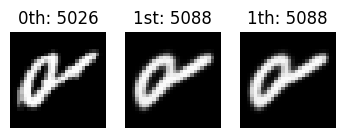

1, 2876.4775390625, 2876.4775390625


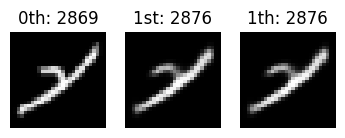

1, 4591.5322265625, 4591.5322265625


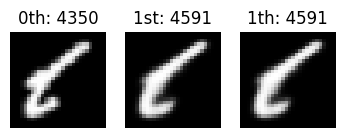

2, 5064.1025390625, 4820.77978515625


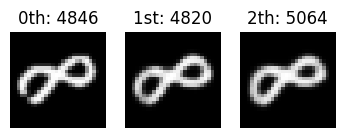

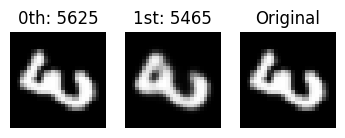

1, 3361.193115234375, 3361.193115234375


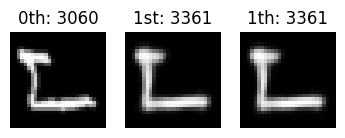

1, 8432.2255859375, 8432.2255859375


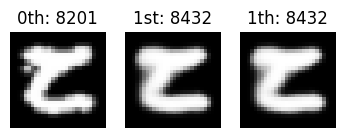

2, 7140.552734375, 7100.029296875


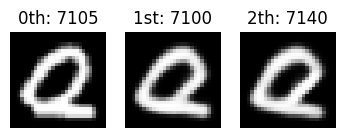

1, 3884.367431640625, 3884.367431640625


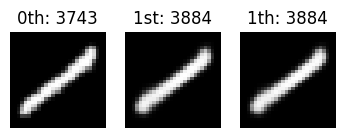

1, 5775.2138671875, 5775.2138671875


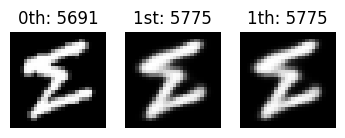

1, 3395.75439453125, 3395.75439453125


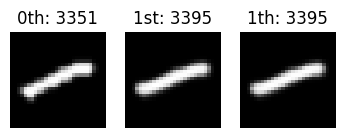

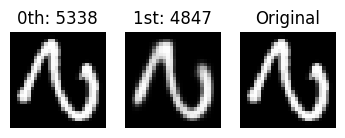

1, 2805.81298828125, 2805.81298828125


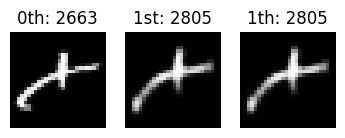

3, 4947.244140625, 4873.63623046875


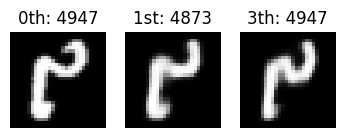

1, 4505.85546875, 4505.85546875


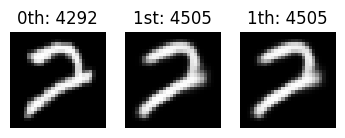

1, 4457.3466796875, 4457.3466796875


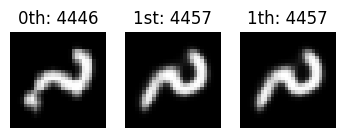

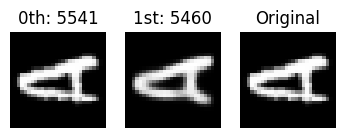

1, 7517.40234375, 7517.40234375


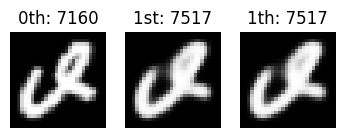

1, 5756.52294921875, 5756.52294921875


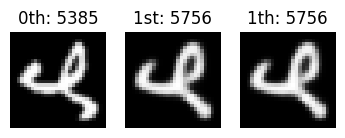

1, 4738.01806640625, 4738.01806640625


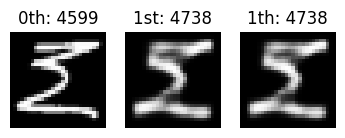

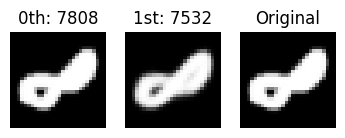

1, 5565.615234375, 5565.615234375


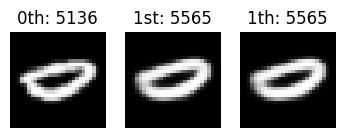

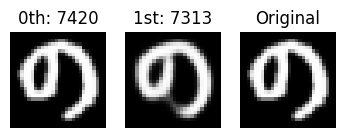

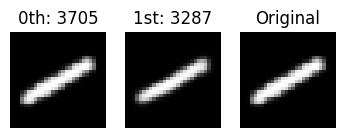

1, 4319.767578125, 4319.767578125


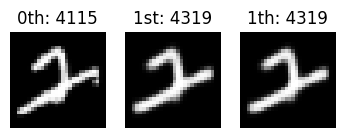

3, 5681.90380859375, 5561.478515625


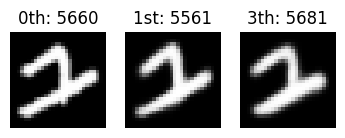

1, 4616.8837890625, 4616.8837890625


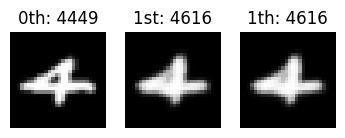

1, 5622.6123046875, 5622.6123046875


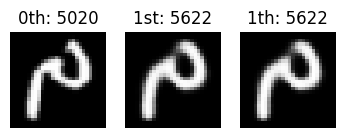

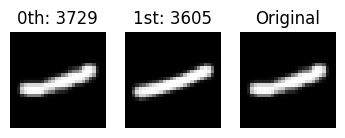

1, 9487.32421875, 9487.32421875


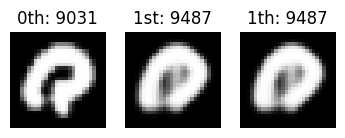

In [9]:
# Testing
data_loader = DataLoader(data_test, batch_size = 250, shuffle = True)
sampling = 5

for data, data_label in data_loader:
    fig, axes = plt.subplots(1, 3, figsize=(6*0.7, 2))
    image = data.to(device)
    values = evaluator(image.reshape(image.size(0),-1))[0]
    image_origin = image[0][0].cpu()
    value_origin = values.sum().item()
    axes[0].imshow(image_origin, cmap='gray')
    axes[0].set_title(f'0th: {int(value_origin)}')
    axes[0].axis('off')  # Turn off axis numbers

    recon_x = image
    count = 0
    for i in range(1, sampling):
        recon_x, mean, log_var = model(recon_x)
        image = recon_x[0].detach()
        values = evaluator(image.reshape(image.size(0),-1))[0]
        value_image = values.sum().item()

        if i == 1:
            value = value_image
            axes[1].imshow(image[0].cpu(), cmap='gray')
            axes[1].set_title(f'1st: {int(value_image)}')
            axes[1].axis('off')  # Turn off axis numbers

        if value_image >= value and value_image > value_origin:
            count += 1
            print(f"{i}, {value_image}, {value}")
            value = value_image
            axes[2].imshow(image[0].cpu(), cmap='gray')
            axes[2].set_title(f'{i}th: {int(value_image)}')
            axes[2].axis('off')  # Turn off axis numbers
            if count == 1:
                break
    if count == 0:
        axes[2].imshow(image_origin, cmap='gray')
        axes[2].set_title(f'Original')
        axes[2].axis('off')  # Turn off axis numbers
    plt.show()
    plt.close()